In [1]:
import geopandas as gpd
import numpy as np
import netCDF4 as nc
from plotting import getIndex, multiVideo, plot2PlusFracNP, plot2PlusFracGeopandas
import shapely.geometry as shg
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
data = gpd.read_file('./data/landkreise_fallzahlen.json')
dateColNames = data.columns[6:-1]
n_obs = data[dateColNames]
nrPlaces, nrTimesteps = n_obs.shape

landkreise = data[data.art == 'landkreis']
bundeslaender = data[data.art == 'bundesland']

In [3]:
dataMarch1918 = nc.Dataset("./data/no2_germany_march2019_1800.nc", "r")
dataMarch1900 = nc.Dataset("./data/no2_germany_march2019_0000.nc", "r")
dataApril1918 = nc.Dataset("./data/no2_germany_april2019_1800.nc", "r")
dataApril1900 = nc.Dataset("./data/no2_germany_april2019_0000.nc", "r")
dataFebr1800 = nc.Dataset("./data/no2_germany_february2020_1800.nc", "r")
dataFebr0000 = nc.Dataset("./data/no2_germany_february2020_0000.nc", "r")
dataMarch1800 = nc.Dataset("./data/no2_germany_march2020_1800.nc", "r")
dataMarch0000 = nc.Dataset("./data/no2_germany_march2020_0000.nc", "r")
dataApril1800 = nc.Dataset("./data/no2_germany_april2020_1800.nc", "r")
dataApril0000 = nc.Dataset("./data/no2_germany_april2020_0000.nc", "r")

Tfeb, X, Y = dataFebr1800['tcno2'].shape
Tmarch, _, _ = dataMarch1800['tcno2'].shape
Tapril, _, _ = dataApril1800['tcno2'].shape
Tmeassure = 21
Tdelta = 30

In [4]:
# beforeVals1800 = np.concatenate((dataFebr1800['tcno2'][-(Tdelta - Tmeassure):], dataMarch1800['tcno2'][:Tmeassure]))
# beforeVals0000 = np.concatenate((dataFebr0000['tcno2'][-(Tdelta - Tmeassure):], dataMarch0000['tcno2'][:Tmeassure]))
beforeVals1800 = np.concatenate((dataMarch1918['tcno2'][Tmeassure:], dataApril1918['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
beforeVals0000 = np.concatenate((dataMarch1900['tcno2'][Tmeassure:], dataApril1900['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
afterVals1800 = np.concatenate((dataMarch1800['tcno2'][Tmeassure:], dataApril1800['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
afterVals0000 = np.concatenate((dataMarch0000['tcno2'][Tmeassure:], dataApril0000['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))

beforeVals1800mean = np.mean(beforeVals1800, axis=0)
beforeVals0000mean = np.mean(beforeVals0000, axis=0)
afterVals1800mean = np.mean(afterVals1800, axis=0)
afterVals0000mean = np.mean(afterVals0000, axis=0)



(<Figure size 1152x360 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f70422f5ef0>,
       dtype=object))

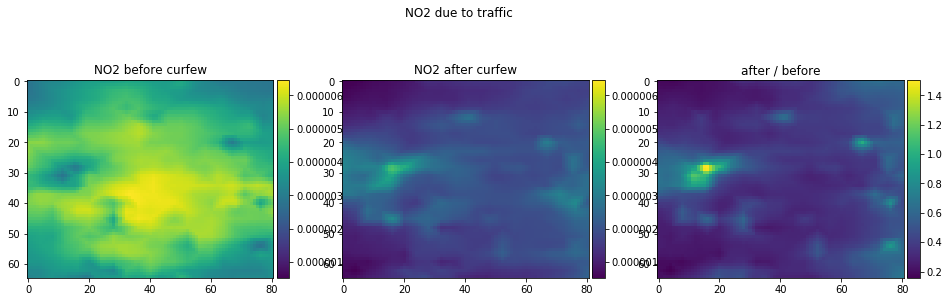

In [5]:
fracNontrafficNight = 0.6
nontraffic = fracNontrafficNight * afterVals0000mean
trafficBefore = beforeVals1800mean - nontraffic
trafficAfter = afterVals1800mean - nontraffic

plot2PlusFracNP('NO2 due to traffic', 'NO2 before curfew', 'NO2 after curfew', 'after / before', trafficBefore, trafficAfter)

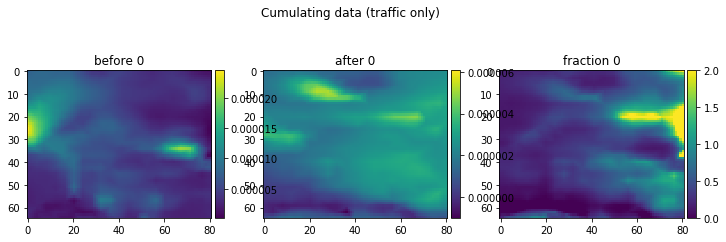

In [6]:
trafficBefore = beforeVals1800 - fracNontrafficNight * beforeVals0000
trafficAfter = afterVals1800 - fracNontrafficNight * afterVals0000
fraction = trafficAfter / trafficBefore
fraction = np.clip(fraction, 0, 2)
T, R, C = beforeVals0000.shape

def cumulate(mtrx):
    T, R, C = mtrx.shape
    newm = np.zeros((T, R, C), dtype=np.float64)
    for t in range(T):
        newm[t] = np.sum(mtrx[:(t+1), :, :], axis=0) / (t+1)
    return newm

datas = [
    cumulate(trafficBefore),
    cumulate(trafficAfter),
    cumulate(fraction)
]
labels = [
    [f"before {i}" for i in range(T)],
    [f"after {i}" for i in range(T)],
    [f"fraction {i}" for i in range(T)]
]
ani = multiVideo('Cumulating data (traffic only)', labels, datas)
# ani.save('./output/cuml_frac_traffic.gif', writer='imagemagick', fps=4)
HTML(ani.to_jshtml())

In [7]:
nrLandkreise = len(landkreise.index)
landkreise['no2_1800_before'] = [[] for i in range(nrLandkreise)]
landkreise['no2_1800_after'] = [[] for i in range(nrLandkreise)]
landkreise['no2_0000_before'] = [[] for i in range(nrLandkreise)]
landkreise['no2_0000_after'] = [[] for i in range(nrLandkreise)]

R, C = beforeVals0000mean.shape
for r in range(R):
    for c in range(C):
        lat = dataMarch1800['latitude'][r]
        lon = dataMarch1800['longitude'][c]
        pt = shg.Point(lon, lat)
        for i in landkreise.index:
            lk = landkreise.loc[i]
            if lk.geometry.contains(pt):
                landkreise.loc[i, 'no2_1800_before'] = landkreise.loc[i, 'no2_1800_before'] +  [beforeVals1800mean[r, c]]
                landkreise.loc[i, 'no2_1800_after'] = landkreise.loc[i, 'no2_1800_after'] +  [afterVals1800mean[r, c]]
                landkreise.loc[i, 'no2_0000_before'] = landkreise.loc[i, 'no2_0000_before'] +  [beforeVals0000mean[r, c]]
                landkreise.loc[i, 'no2_0000_after'] = landkreise.loc[i, 'no2_0000_after'] +  [afterVals0000mean[r, c]]
                break


In [8]:
landkreise['obs_no2_mean_before'] = landkreise['no2_1800_before'].apply(np.mean)
landkreise['obs_no2_mean_after'] = landkreise['no2_1800_after'].apply(np.mean)
landkreise['obs_no2_midnight_mean_before'] = landkreise['no2_0000_before'].apply(np.mean)
landkreise['obs_no2_midnight_mean_after'] = landkreise['no2_0000_after'].apply(np.mean)

In [9]:
# some small LKs have no meassurements of NO2. Copy from their neighbors
for i in range(nrPlaces):
    row0 = landkreise.loc[i]
    if np.isnan(row0['obs_no2_mean_after']):
        for j in range(nrPlaces):
            row1 = landkreise.loc[j]
            if not (np.isnan(row1['obs_no2_mean_after'])) and row1.geometry.touches(row0.geometry):
                landkreise.loc[i, 'obs_no2_mean_after'] = row1['obs_no2_mean_after']
                landkreise.loc[i, 'obs_no2_mean_before'] = row1['obs_no2_mean_before']
                landkreise.loc[i, 'obs_no2_midnight_mean_after'] = row1['obs_no2_midnight_mean_after']
                landkreise.loc[i, 'obs_no2_midnight_mean_before'] = row1['obs_no2_midnight_mean_before']
                break

In [10]:
landkreise.drop('no2_1800_before', 1, inplace=True)
landkreise.drop('no2_1800_after', 1, inplace=True)
landkreise.drop('no2_0000_before', 1, inplace=True)
landkreise.drop('no2_0000_after', 1, inplace=True)

landkreise.to_file("./data/landkreise_no2_30d.json", driver="GeoJSON", encoding="utf-8")

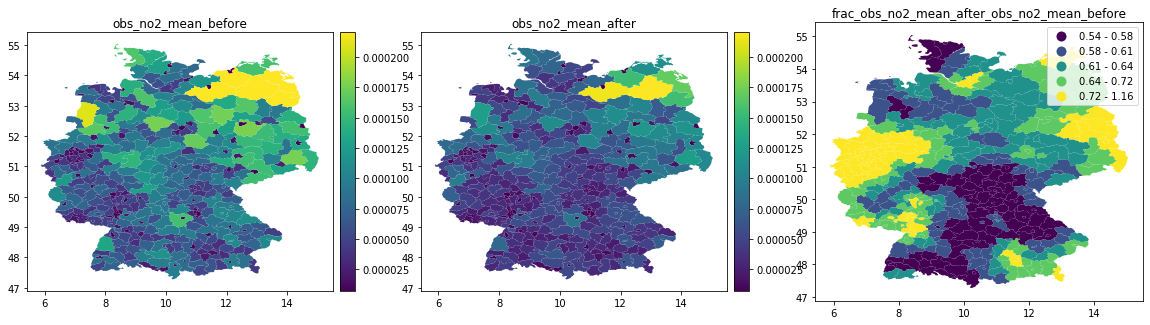

In [11]:
plot2PlusFracGeopandas(landkreise, 'obs_no2_mean_before', 'obs_no2_mean_after')

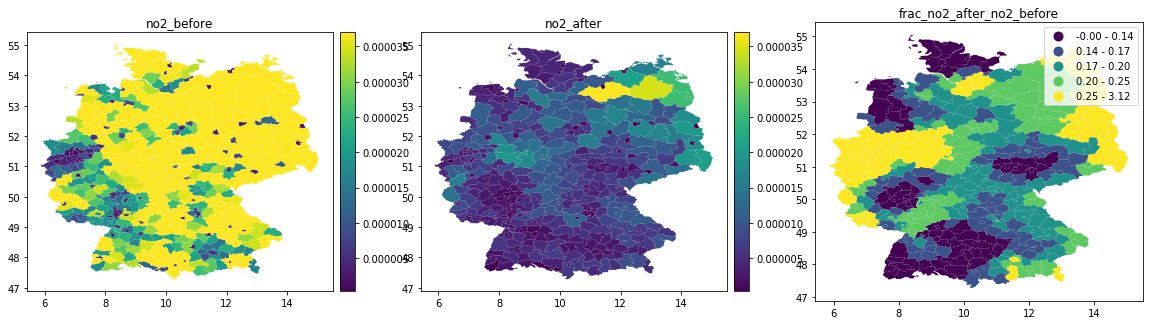

In [12]:
fracNontrafficMidnight = 0.8
nontraffic = fracNontrafficMidnight * landkreise['obs_no2_midnight_mean_after']
landkreise['no2_before'] = landkreise['obs_no2_mean_before'] - nontraffic
landkreise['no2_after'] = landkreise['obs_no2_mean_after'] - nontraffic
plot2PlusFracGeopandas(landkreise, 'no2_before', 'no2_after')